dt: %f, critical dt: %f 163.3986928104575 16339869281.04575
Conduction:  1.0
End time:  100.01


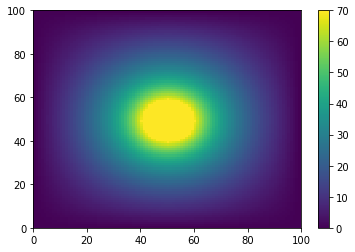

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

# box size, m
w = h = 1.
# intervals in x-, y- directions, m
dx = dy = 0.01
# Thermal diffusivity, m2.s-1
alpha = 1.53e-7
# Porosity
n = 0.4
# Viscosity kg/m
nu = 1.00E-03 
# Permeability m2
k = 1e-15
# Thermal expansion 
beta = 8.80E-05
# Cf
cf = 4290
# rhow
rhow = 1030

# Disable conduction
conduction = 1.

Tcool, Thot = 0, 70

nx, ny = int(w/dx), int(h/dy)

dx2, dy2 = dx*dx, dy*dy
dt = dx2 * dy2 / (2 * alpha * (dx2 + dy2))

print("dt: %f, critical dt: %f", dt, 1/(2 * alpha * (dx2 + dy2)))
dt = 0.01

u0 = Tcool * np.ones((nx, ny))
u = u0.copy()

uu = []

# Initial conditions - ring of inner radius r, width dr centred at (cx,cy) (mm)
r, cx, cy = 0.1, 0.5, 0.5
r2 = r**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = Thot

def do_timestep(u0, u):
    # Propagate with forward-difference in time, central-difference in space, upwind solution for advection
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + \
     + conduction * alpha * dt * 3600* ((u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2 + \
          (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2) + \
    dt * 3600 * (1/(n*nu)*k*9.81*rhow)*(1 - beta*(u0[1:-1,1:-1]-Tcool)) * \
    (u0[2:,1:-1] - u0[1:-1,1:-1])/(dy)

    for i in range(nx):
        for j in range(ny):
            p2 = (i*dx-cx)**2 + (j*dy-cy)**2
            if p2 < r2:
                u[i,j] = Thot

    u0 = u.copy()
    return u0, u

# Number of timesteps
nsteps = 10001
for m in range(nsteps):
    u0, u = do_timestep(u0, u)
    uu.append(u.copy())

print("Conduction: ", conduction)
print("End time: ", dt * nsteps)

fig = plt.figure()
pcm = plt.pcolormesh(np.flipud(uu[len(uu)-1]))
plt.colorbar()    

In [ ]:
def step(i):
    j = int(nsteps/100*i)
    pcm.set_array(np.flipud(uu[j]).ravel())
    plt.draw()

anim = FuncAnimation(fig, step, interval=50)
HTML(anim.to_html5_video())